<a href="https://colab.research.google.com/github/jb2467/SMRG_Video/blob/main/SMRG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hello
# Using first study as training, second as validation, could still be 60/20/20
# standarized AOI
# Rules:
##

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch as pt
import torch.nn.functional
import os
import cv2
from google.colab.patches import cv2_imshow


In [3]:
path = '/content/drive/MyDrive/SMRG/DFM 1/'

print(os.listdir(path))

subfolders = [f for f in os.listdir(path)]

videos = []

for subfolder in subfolders:
  files = os.listdir(path + '/' + subfolder)
  for file in files:
      videos.append(path + '/' + subfolder + '/' + file)
print(videos)



['Participant 16', 'Participant 19', 'Participant 20', 'Participant15']
['/content/drive/MyDrive/SMRG/DFM 1//Participant 16/P3', '/content/drive/MyDrive/SMRG/DFM 1//Participant 16/P2', '/content/drive/MyDrive/SMRG/DFM 1//Participant 19/P2', '/content/drive/MyDrive/SMRG/DFM 1//Participant 19/P3', '/content/drive/MyDrive/SMRG/DFM 1//Participant 20/P2', '/content/drive/MyDrive/SMRG/DFM 1//Participant 20/P3', '/content/drive/MyDrive/SMRG/DFM 1//Participant15/P2', '/content/drive/MyDrive/SMRG/DFM 1//Participant15/P3']


/content/drive/MyDrive/SMRG/DFM 1/Participant15/P3/P 3 - Resp P 15 (1).mp4
   start_time  gaze_x  gaze_y  radius  duration  end_time
0    0.533333    1254     454      14  0.233333  0.766667
1    0.833333     764     480      13  0.333333  1.166667
2    1.433333     762     424      12  0.400000  1.833333
3    2.066667    1300     596      12  0.233333  2.300000
4    2.366667    1420     546      11  0.200000  2.566667
5    2.800000    1274     464      13  0.300000  3.100000
6    3.133333    1262     414      12  0.233333  3.366667
7    3.433333    1390     568      11  0.466667  3.900000
8    4.000000     828     472      11  0.233333  4.233333
(9, 6)
Total gaze points detected: 116
    timestamp  gaze_x  gaze_y  radius
0    0.033333    1294     582      12
1    0.066667    1294     576      12
2    0.100000    1294     566      12
3    0.133333    1296     558      13
4    0.166667    1298     554      13
5    0.200000    1312     546      13
6    0.233333    1412     524      11
7 

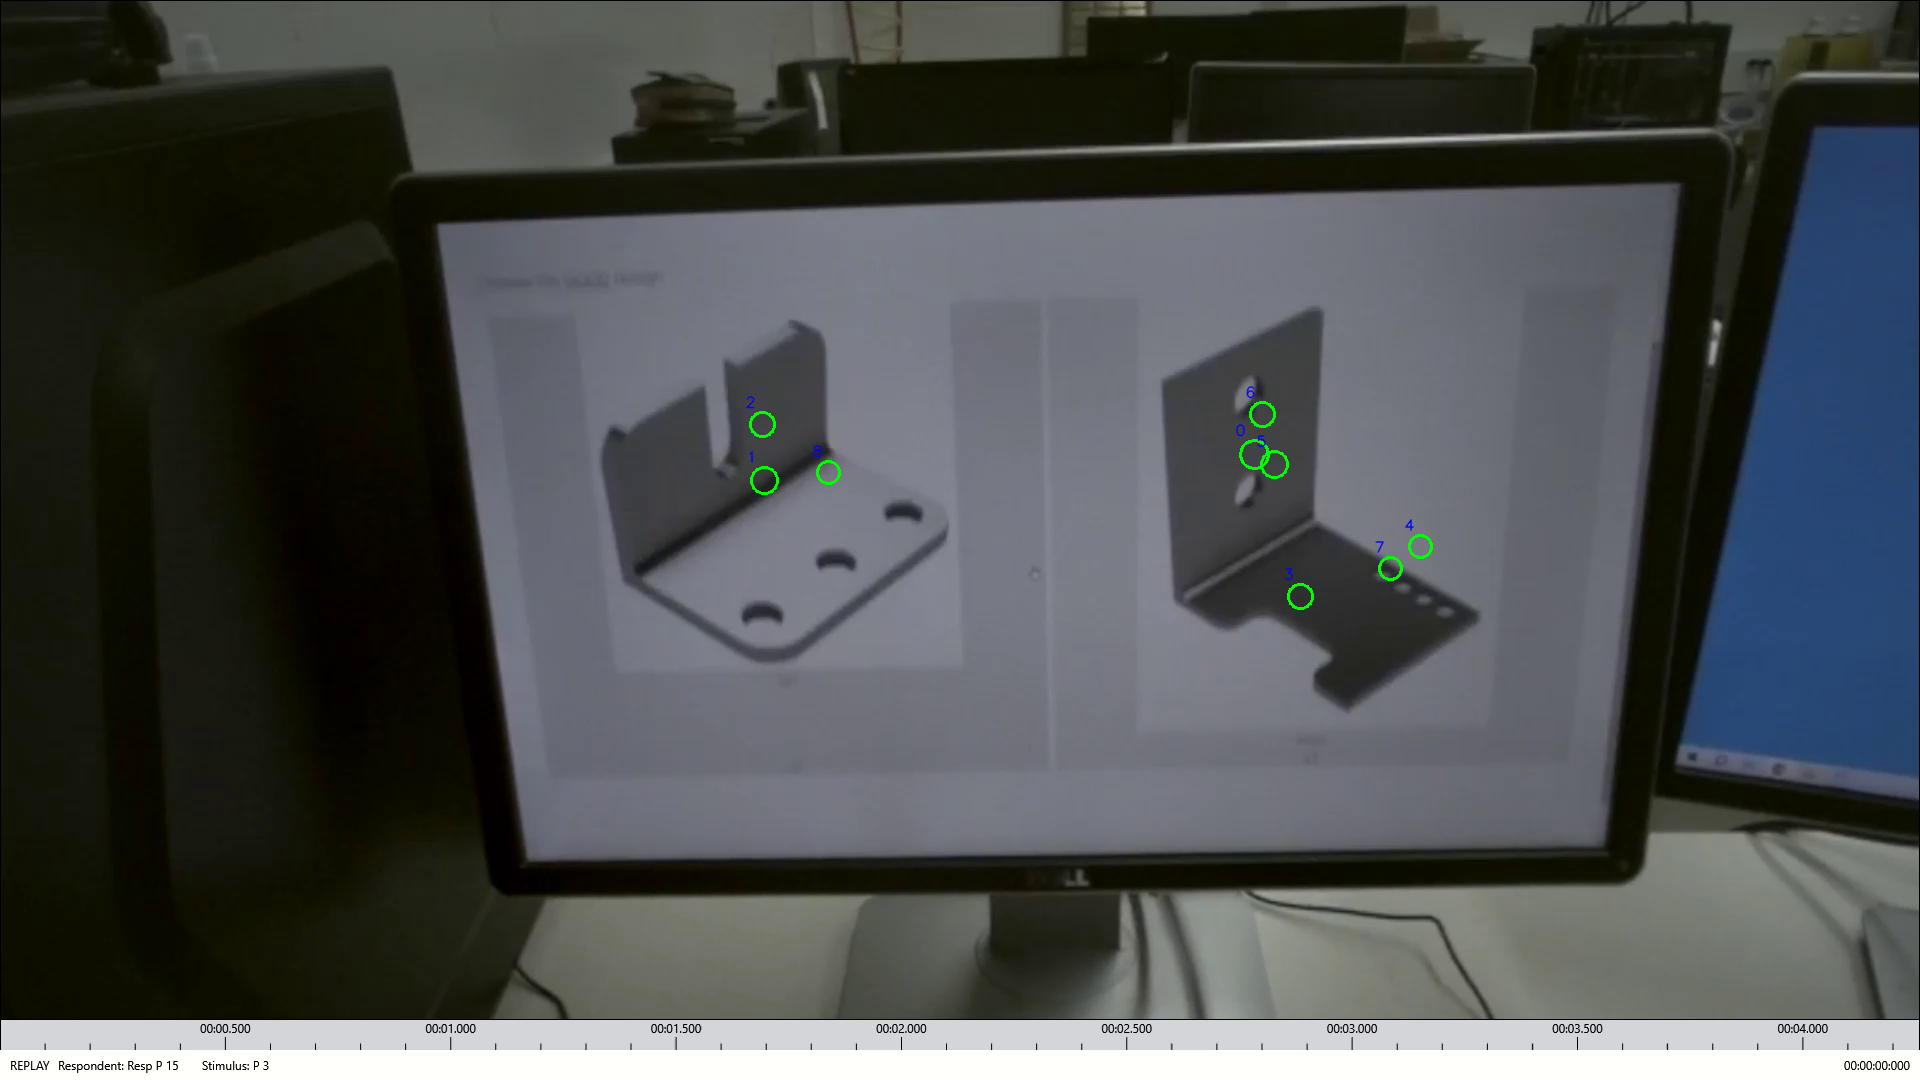

In [33]:
#20ms between fixations

def analyze_eye_tracking_video(video_file, movement_threshold=5, min_fixation_duration=0.200, grace_period_frames=10):
    cap = cv2.VideoCapture(video_file)
    gaze_data = []
    prev_x, prev_y = None, None  # Track previous gaze point
    start_time = None
    grace_period_counter = 0
    raw_gaze_data = []
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_file}")
        return None

    # Use actual FPS from video file
    fps = cap.get(cv2.CAP_PROP_FPS)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Use actual time per frame for more accurate timestamps
        current_time_raw = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000  # Get timestamp in seconds

        gray = cv2.GaussianBlur(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (5, 5), 0)
        circles = cv2.HoughCircles(
            gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=5, maxRadius=30
        )

        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            for (x, y, r) in circles:
                grace_period_counter = 0  # Reset grace period
                raw_gaze_data.append([current_time_raw, x, y, r])

                if prev_x is not None and prev_y is not None:
                    distance_moved = np.sqrt((x - prev_x)**2 + (y - prev_y)**2)

                    if distance_moved > movement_threshold:
                        fixation_duration = current_time_raw - start_time
                        if fixation_duration >= min_fixation_duration:
                            end_time = start_time + fixation_duration
                            gaze_data.append([start_time, prev_x, prev_y, r, fixation_duration, end_time])

                        start_time = current_time_raw  # Reset start time for new fixation
                    prev_x, prev_y = x, y  # Update previous gaze point
                else:
                    start_time = current_time_raw  # Start new fixation
                    prev_x, prev_y = x, y

                break  # Use only the first circle detected
        else:
            grace_period_counter += 1
            if grace_period_counter > grace_period_frames and prev_x is not None:
                fixation_duration = current_time_raw - start_time
                if fixation_duration >= min_fixation_duration:
                    end_time = start_time + fixation_duration
                    gaze_data.append([start_time, prev_x, prev_y, 0, fixation_duration, end_time])

                prev_x, prev_y = None, None  # Reset when fixation ends

    cap.release()

    df = pd.DataFrame(gaze_data, columns=['start_time', 'gaze_x', 'gaze_y', 'radius', 'duration', 'end_time'])

    # Merge similar fixations if needed
    raw_df = pd.DataFrame(raw_gaze_data, columns=['timestamp', 'gaze_x', 'gaze_y', 'radius'])
    return df, raw_df

# Helper function to merge similar fixations (provided in the original code)

def display_fixations_on_video(video_file, gaze_df):
    cap = cv2.VideoCapture(video_file)

    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_file}")
        return

    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to read the first frame")
        return

    real_frame = frame.copy()

    for index, row in gaze_df.iterrows():
        x, y, r = int(row['gaze_x']), int(row['gaze_y']), int(row['radius'])
        cv2.circle(real_frame, (x, y), r, (0, 255, 0), 2)
        cv2.putText(real_frame, str(index), (x - r - 5, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 0, 0), 1, cv2.LINE_AA)
    cv2_imshow(real_frame)

    cap.release()
# Example usage
video_file = '/content/drive/MyDrive/SMRG/DFM 1/Participant15/P3/P 3 - Resp P 15 (1).mp4'
print(video_file)
gaze_df, raw_df = analyze_eye_tracking_video(video_file)

if gaze_df is not None:
    print(gaze_df.tail(20))
    print(gaze_df.shape)
    print(f"Total gaze points detected: {raw_df.shape[0]}")
    print(raw_df.head(20))
    display_fixations_on_video(video_file, gaze_df)
else:
    print("No valid gaze data to display.")


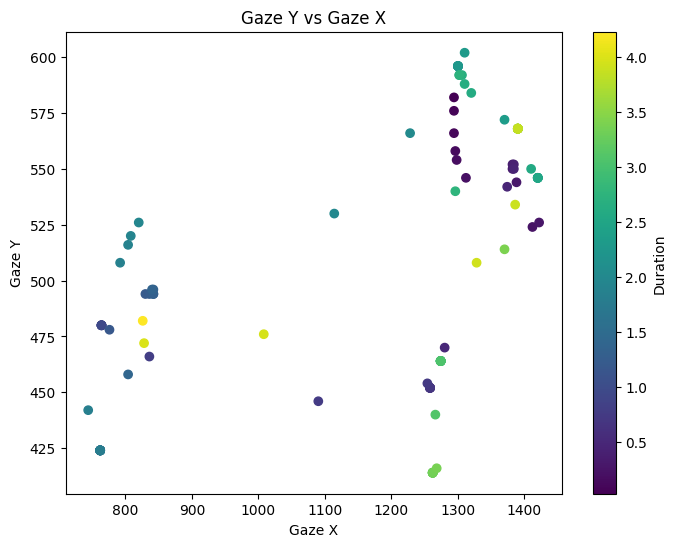

In [5]:

plt.figure(figsize=(8, 6))
plt.scatter(raw_df['gaze_x'], raw_df['gaze_y'], c=raw_df['timestamp'], cmap='viridis')
plt.xlabel('Gaze X')
plt.ylabel('Gaze Y')
plt.title('Gaze Y vs Gaze X')
_ = plt.colorbar(label='Duration')

In [6]:
gaze_df.shape

(9, 6)

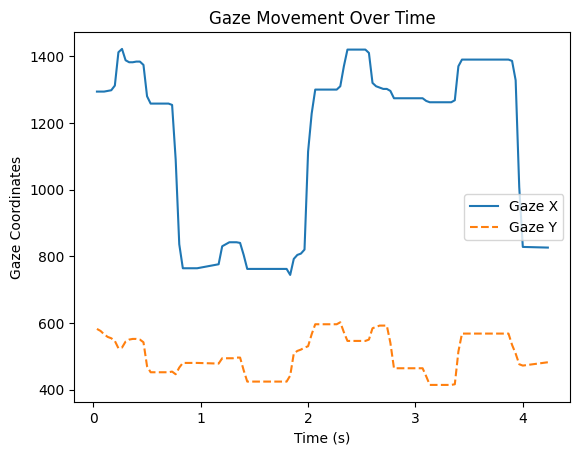

In [11]:
plt.plot(raw_df['timestamp'], raw_df['gaze_x'], label='Gaze X')
plt.plot(raw_df['timestamp'], raw_df['gaze_y'], label='Gaze Y', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Gaze Coordinates')
plt.legend()
plt.title('Gaze Movement Over Time')
plt.show()


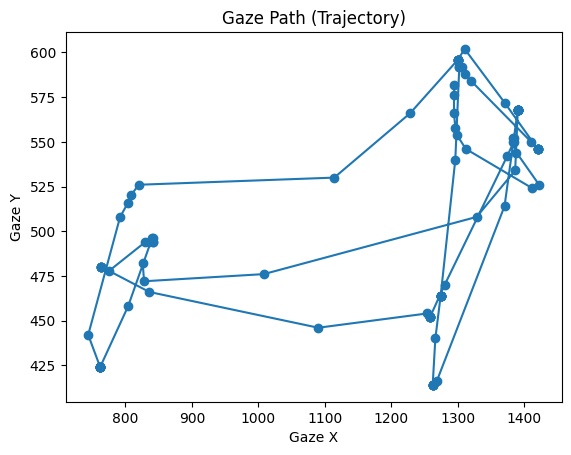

In [8]:
plt.plot(raw_df['gaze_x'], raw_df['gaze_y'], marker='o', linestyle='-')
plt.xlabel('Gaze X')
plt.ylabel('Gaze Y')
plt.title('Gaze Path (Trajectory)')
plt.show()


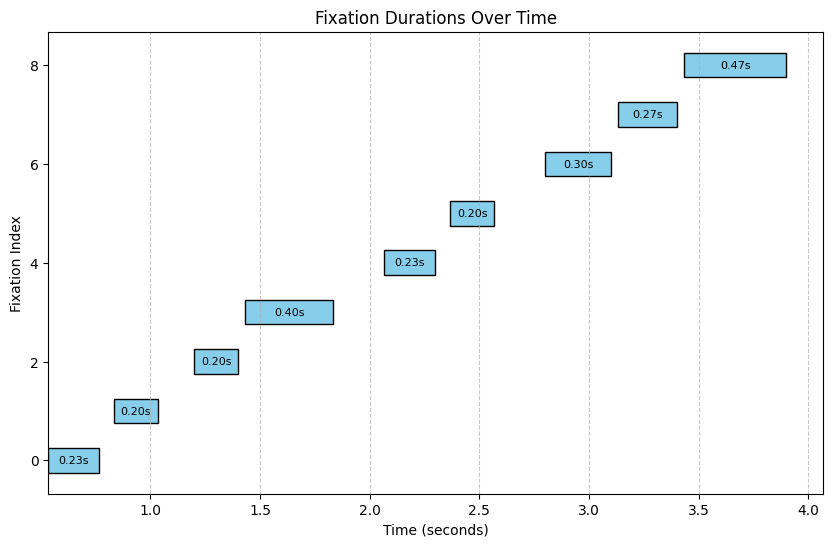

In [9]:

def plot_fixations(gaze_df):
    fig, ax = plt.subplots(figsize=(10, 6))

    for idx, row in gaze_df.iterrows():
        start = row['start_time']
        duration = row['duration']

        ax.barh(idx, duration, height=0.5, left=start, align='center', color='skyblue', edgecolor='black')
        ax.text(start + duration / 2, idx, f"{duration:.2f}s", ha='center', va='center', fontsize=8)

    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Fixation Index')
    ax.set_title('Fixation Durations Over Time')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.show()

if gaze_df is not None and not gaze_df.empty:
    plot_fixations(gaze_df)
else:
    print("No valid fixation data to plot.")


sns

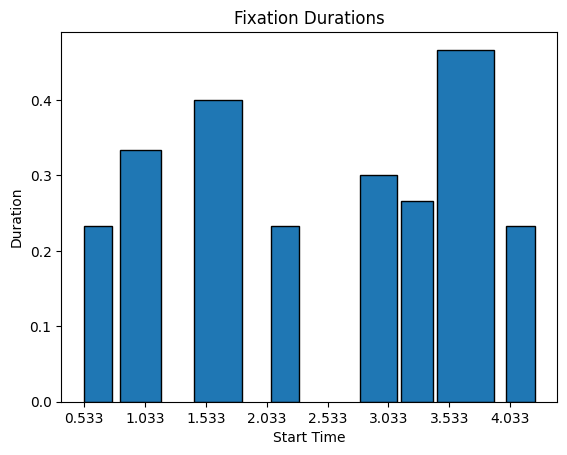

In [29]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()

start_times = gaze_df['start_time']
durations = gaze_df['duration']

ax.bar(start_times, durations, width=durations, align='edge', edgecolor='black')

ax.set_xlabel('Start Time')
ax.set_ylabel('Duration')
ax.set_title('Fixation Durations')

ax.set_xticks(np.arange(min(start_times), max(start_times) + 0.5, 0.5))

plt.show()